In [65]:

import datetime
from datetime import date, timedelta
import math
import itertools
import time
import cv2
from scipy.ndimage import gaussian_filter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import os
from pathlib import Path
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft2
import cmocean
import matplotlib
from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"] = 14, 12
%matplotlib inline

In [66]:
def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #if MUR data, rename columns and convert temperature to Celsius (the data must be saved as 'mur...nc')
    if data.startswith('mur') or data.startswith('sst'): 
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [69]:
df_ex = get_data('sst_20220615.nc')

In [70]:
df_ex

,latitude,longitude,time,thetao
0,35.0,-19.000000,2022-06-15 09:00:00,19.606995
1,35.0,-18.990000,2022-06-15 09:00:00,19.595001
2,35.0,-18.980000,2022-06-15 09:00:00,19.583008
3,35.0,-18.969999,2022-06-15 09:00:00,19.571991
4,35.0,-18.959999,2022-06-15 09:00:00,19.559998
...,...,...,...,...
1402396,45.0,-5.040000,2022-06-15 09:00:00,18.338013
1402397,45.0,-5.030000,2022-06-15 09:00:00,18.338989
1402398,45.0,-5.020000,2022-06-15 09:00:00,18.339996
1402399,45.0,-5.010000,2022-06-15 09:00:00,18.339996


In [67]:
cmems = get_data('CMEMS_forecast_2022-07-18.nc')

In [68]:
cmems

,latitude,longitude,time,thetao
0,35.0,-19.000000,2022-07-18 12:30:00,21.688000
1,35.0,-18.972221,2022-07-18 12:30:00,21.656000
2,35.0,-18.944445,2022-07-18 12:30:00,21.605000
3,35.0,-18.916666,2022-07-18 12:30:00,21.563000
4,35.0,-18.888889,2022-07-18 12:30:00,21.548000
...,...,...,...,...
182300,45.0,-5.111111,2022-07-18 12:30:00,21.221001
182301,45.0,-5.083333,2022-07-18 12:30:00,21.224001
182302,45.0,-5.055555,2022-07-18 12:30:00,21.209000
182303,45.0,-5.027778,2022-07-18 12:30:00,21.177002


In [90]:
def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory inside the MUR_seasonal_data folder and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    base_path = os.getcwd()
    data_folder = os.path.join(base_path, "../data")  
    
    nc_path = os.path.join(data_folder, data)
    data_xarray = xr.load_dataset(nc_path)
    
    
    data_xarray = data_xarray.rename({'latitude':'lat', 'longitude':'lon', 'thetao':'analysed_sst'})
    
    return data_xarray

In [91]:
ex = get_data('CMEMS_forecast_2022-07-18.nc')

In [92]:
ex

<xarray.Dataset>
Dimensions:       (lat: 361, lon: 505, time: 1)
Coordinates:
  * lat           (lat) float32 35.0 35.03 35.06 35.08 ... 44.94 44.97 45.0
  * time          (time) datetime64[ns] 2022-07-18T12:30:00
  * lon           (lon) float32 -19.0 -18.97 -18.94 ... -5.056 -5.028 -5.0
Data variables:
    analysed_sst  (time, lat, lon) float32 21.69 21.66 21.6 ... 21.18 21.13
Attributes: (12/24)
    Conventions:                        CF-1.0
    source:                             IBI-MFC (PdE Production Center)
    institution:                        Puertos del Estado (PdE)
    title:                              Ocean surface hourly mean fields for ...
    easting:                            longitude
    northing:                           latitude
    ...                                 ...
    z_min:                              0.494025f
    z_max:                              0.494025f
    contact:                            mailto: servicedesk.cmems@mercator-oc...
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention
    comment:                            
    history:                            Data extracted from dataset http://lo...

In [81]:
ex['lat']

KeyError: 'lat'

# -------------------------------------- CANNY ----------------------------------------------

In [63]:


# Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
sst = df_ex.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
#Convert Temperature values to uint8 format with values in the range of 0-255
sst_final = ((sst - np.nanmin(sst)) * (1/(np.nanmax(sst) - np.nanmin(sst)) * 255)).astype('uint8')
sst_final = np.flipud(sst_final)   #flipud -> Reverse the order of elements along axis 0 (up/down).
#in case we want to apply a gaussian filter with a certain sigma value (by default is 0)
sst_final = gaussian_filter(sst_final, sigma=5)   


#apply the canny algorithm and plot the image with the edges
canny = cv2.Canny(sst_final, 120, 220, apertureSize=5, L2gradient=False)  #max = 255, min = 0

canny[canny == 255] = 1

#Apply a mask for the continental zone:
mask = np.isnan(np.flipud(sst))    #Boolean array: True where array Temp had Null Values (correspond to the continental zone)
#mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which values= 255 when mask=True
#Dilation to ensure that the pixels that belong to the "shore/continental zone" are not considered fronts 
#kernel = np.ones((3,3), np.uint8)
#mask_dilated = cv2.dilate(mask255, kernel)
canny_front =np.ma.masked_array(canny, mask)   #Mask an array where a condition is True

#canny_front.astype('float32')

#canny_front[canny_front == 255] = np.nan

canny_front = np.flipud(canny_front) 



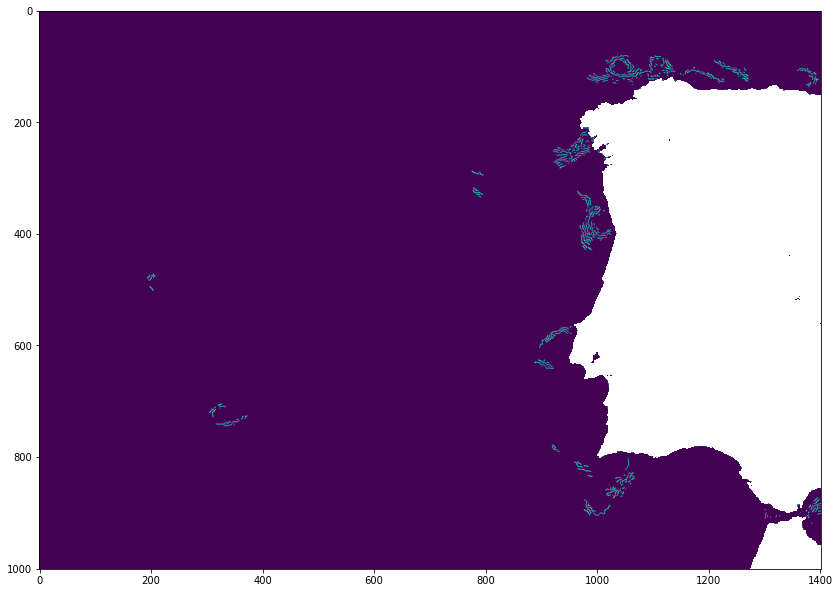

In [62]:
plt.rcParams["figure.figsize"] = 14, 12
plt.imshow(canny_front)

In [38]:
canny_front.min()

0

In [64]:
canny_front

masked_array(
  data=[[0, 0, 0, ..., --, --, --],
        [0, 0, 0, ..., --, --, --],
        [0, 0, 0, ..., --, --, --],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=999999,
  dtype=uint8)

In [40]:
np.unique(canny_front)

masked_array(data=[0, 1, --],
             mask=[False, False,  True],
       fill_value=999999,
            dtype=uint8)

In [360]:
canny_front.min()

0

In [41]:

# Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
sst2 = df_ex.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values
#Convert Temperature values to uint8 format with values in the range of 0-255
sst_final2 = ((sst2 - np.nanmin(sst)) * (1/(np.nanmax(sst2) - np.nanmin(sst2)) * 255)).astype('uint8')
sst_final2 = np.flipud(sst_final2)   #flipud -> Reverse the order of elements along axis 0 (up/down).
#in case we want to apply a gaussian filter with a certain sigma value (by default is 0)
sst_final2 = gaussian_filter(sst_final2, sigma=5)   


#apply the canny algorithm and plot the image with the edges
canny2 = cv2.Canny(sst_final2, 120, 220, apertureSize=5, L2gradient=False)  #max = 255, min = 0

canny2[canny2 == 255] = 1

#Apply a mask for the continental zone:
mask2 = np.isnan(np.flipud(sst2))    #Boolean array: True where array Temp had Null Values (correspond to the continental zone)
mask255 = np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which values= 255 when mask=True
#Dilation to ensure that the pixels that belong to the "shore/continental zone" are not considered fronts 
kernel = np.ones((3,3), np.uint8)
mask_dilated = cv2.dilate(mask255, kernel)
canny_front2 =np.ma.masked_where(mask_dilated==255, canny2)   #Mask an array where a condition is True

#canny_front.astype('float32')

#canny_front[canny_front == 255] = np.nan

#canny_front = np.flipud(canny_front) 


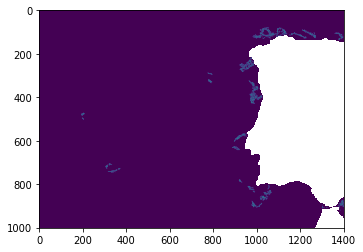

In [42]:
plt.imshow(canny_front2)

In [43]:
canny_front2

masked_array(
  data=[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., --, --, --],
        [0, 0, 0, ..., --, --, --],
        [0, 0, 0, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

# ------------------------------------- BOA -----------------------------------------------

In [276]:
def filt5(lon, lat, ingrid, nodata=np.nan):
    """
    Find peaks in 5 directions. Flag as 5
    Finds maximum of a 5x5 sliding window. If the central pixel is the maximum, this is flagged as a one.
    All other pixels are flagged as zero.
    """
    
    nodatidx = ingrid.flatten()*np.nan     # creates 1D array with as much values as the matrix ingrid, with NANs
    outgrid = np.zeros(ingrid.shape)       # outgrid is a matrix with the shape of ingrid, full of Zeros

    l1 = len(lat)
    l2 = len(lon)

    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            subg = ingrid[(i-3):(i+2), (j-3):(j+2)]   #return the last 5 rows of the last 5 columns of the matrix
            if np.isnan(subg).sum()==25:              #if all values in submatrix subg are null values:
                outgrid[i,j] = 0
            else:
                vec = np.array(subg).T.flatten()    # array with values of the transpose subg matrix
                ma = np.argmax(subg.flatten())      # index with the maximum value of subg array
                mi = np.argmin(subg.flatten())      # index with the minimum value of subg array
                
                if ma==12 or mi==12:     #if ma or mi is the middle value of 5X5 matrix (if the central pixel is the maximum)
                    outgrid[i-1,j-1] = 1      #flagged as 1
                else:
                    outgrid[i-1,j-1] = 0      #all other pixels are flagged as 0
    
    return outgrid

In [277]:
def filt3(lon, lat, ingrid, grid5):
    """
    Find peaks in 3 directions. FLag as 3
    Returns a median smoothed grid of satellite data
    """
    
    outgrid = ingrid*0   # matrix of 0s with shape of ingrid matrix
    l1 = len(lat)
    l2 = len(lon)
    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            if (grid5[i,j]==0):
                subg = ingrid[(i-2):(i+1), (j-2):(j+1)]       # submatrix subg (3x3) 
                if np.isnan(subg).sum()==9:                   # if all values in submatrix subg (3x3) are null values:
                    outgrid[i-1,j-1] = ingrid[i-1,j-1]
                else:
                    vec = np.array(subg).T.flatten()          # array with values of the transpose subg matrix
                    ma = np.argmax(subg.flatten())            # index with the maximum value of subg array
                    mi = np.argmin(subg.flatten())            # index with the minimum value of subg array
                    
                    if (ma==4 or mi==4):                      #if ma or mi is the middle value of 3X3 matrix
                        outgrid[i-1,j-1] = nanmedian(subg)    # median while ignoring NaNs.
                    else:
                        outgrid[i-1,j-1] = ingrid[i-1,j-1]
            
            else:
                outgrid[i-1,j-1] = ingrid[i-1,j-1]
                
    return outgrid

In [278]:
def boa(lon, lat, ingrid, nodata = np.nan, direction = False):
    
    def filter2(x, filt):
        """
        Workhorse filter from EBImage. Modified so we don't need colorspace and other annoying requirements
        """
        
        dx = x.shape                          
        df = filt.shape  
        
        if (df[0]//2 == 0) or (df[1]//2 == 0):
            sys.exit('dimensions of "filter" matrix must be odd')
        if (dx[0] < df[0]) or (dx[1] < df[1]):
            sys.exit("dimensions of 'x' must be bigger than 'filter'")
            
        cx = tuple(elem//2 for elem in dx)    
        cf = tuple(elem//2 for elem in df)    

        wf = np.zeros(shape=dx)                                   #matrix with zeros with shape of x

        wf[cx[0]-cf[0]-1:cx[0]+cf[0], cx[1]-cf[1]-1:cx[1]+cf[1]] = filt    #put values of filt in middle of matrix wf

        wf = fft2(wf)                                      #apply the 2 dimensional discrete fourier transform                  
    
        dim_x = np.array(dx[0:2])
        dim_x =np.append(dim_x, math.prod(dx)/math.prod(dx[0:2]))     

        aux1 = np.arange(cx[0],dx[0]+1)
        aux2 = np.arange(1,cx[0])
        index1 = np.concatenate((aux1, aux2), axis=None)  
        index1 = index1-1   

        aux3 = np.arange(cx[1], dx[1]+1)
        aux4 = np.arange(1,cx[1])
        index2 = np.concatenate((aux3, aux4), axis=None) 
        index2 = index2-1   
        #this indices will be used to reorder values of matrix y
        
        y = (scipy.fft.ifft2(scipy.fft.fft2(x)*wf)).real

        y = np.array([[y[i][j] for j in index2] for i in index1])
        
        return y
    
#======================================================#
# Main BOA algorithm                                   
#======================================================#      
    gx = np.matrix([[-1,0,1],[-2,0,2],[-1,0,1]])        #filter in x
    gy = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])        #filter in y
        
    np.nan_to_num(ingrid, nan=-9999, posinf=-9999, neginf=-9999)    #replace NaN and inf values with -9999
        
    grid5 = filt5(lon, lat, ingrid, nodata = nodata)
    grid35 = filt3(lon, lat, ingrid, grid5)

    # make an index of bad values and land pixels.
    grid35 = grid35.astype("float")
    grid35[grid35 == -9999]=np.nan
    naidx = np.isnan(grid35)        #matrix with shape of grid35 (True if value is nan, False otherwise)
    # convert these (True values of naidx) to zeros (in grid35) for smoothing purposes
    grid35[naidx]=0  

    # perform the smoothing (Sobel filter)  
    tgx = filter2(grid35, gx)
    tgy = filter2(grid35, gy)
        
    tx = tgx/np.nansum(abs(np.array(gx).flatten()))    
    ty = tgy/np.nansum(abs(np.array(gy).flatten()))    
    front = np.sqrt((tx**2)+(ty**2))                   

#======================================================#
# landmask and edge dilation
#======================================================#

    land = naidx*1
    land = land.astype("float")

    land[land==1] = np.nan
    land[~np.isnan(land)] = 1

    
#======================================================#
# landmask and edge dilation using raster!
#======================================================#

    l2=lon.size    
    l1=lat.size

    midx = land*np.nan

    midx[5:(l1-2), 5:(l2-2)] = 1

    land = np.multiply(land, midx)
    
    
    ssr = np.flip(front.T, 0)
    

    #Apply a sliding window kernell to the land matrix
    mask = scipy.signal.convolve2d(np.flip(land.T, 0), np.array([0,0,0,0,1,0,0,0,0]).reshape(3,3), boundary='symm', mode='same')

    matrix_front =  mask * np.flip(front.T, 0)         #matrix of mask raster file * matrix of ssr raster file


    
    if direction==True:
#   ************************************
#   *** Calculate Gradient Direction ***
#   ************************************
        
        n = ingrid.size                                      #nr of elements of the grid matrix
        grid_shape = ingrid.shape

        GRAD_DIR = np.zeros(n)                               #matrix of zeros with shape of ingrid matrix

        for i in range(n):
            GRAD_DIR[i] = math.atan2(tgy.flatten()[i], tgx.flatten()[i])
    
        GRAD_DIR = GRAD_DIR*180/math.pi                      #change radians to degrees

        OK = np.where(GRAD_DIR < 0)

        OK = np.array(OK)

        if OK.size >1:
            GRAD_DIR[OK] = 360 - abs(GRAD_DIR[OK])    #Adjust to 0-360 scheme (make negative degrees positive)
    
        GRAD_DIR = (360 - GRAD_DIR + 90) % 360     #Convert degrees so that 0 degrees is North and East is 90 degrees
        GRAD_DIR = GRAD_DIR.reshape(grid_shape)
        
        
        grad_dir = np.flip(GRAD_DIR.T, 0)


        # create array grdir (result from multiplication of grad_dir_matrix and mask_matrix (its the conv matrix))
        grdir_matrix = np.flip(GRAD_DIR.T, 0)*mask


        dic = {'grdir': grdir_matrix, 'front': matrix_front}
        
    else:
        matrix_front

        
    return matrix_front

In [279]:
def BOA_aplication(df, threshold = 0.05):  
    
    """
    Function to, for a given dataframe with a longitude, latitude and SST columns, 
    identifies fronts through the application of BOA algorithm.
    We also need to define a threshold value to later get the frontal probabilities matrix
    (if the pixel value is greater than the threshold, then it is considered a front, otherwise don't). 
    """
    
    lat = np.array(df['lat'].unique())
    lon = np.array(df['lon'].unique())
    ingrid = np.array(df['analysed_sst']).reshape(len(lat), len(lon))
    
    boa_front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    boa_front = np.flip(boa_front, axis=0)
    boa_front = np.array([[boa_front[j][i] for j in range(len(boa_front))] for i in range(len(boa_front[0])-1,-1,-1)])
    
    boa_front = np.where(boa_front>=threshold, 1, boa_front)    
    boa_front = np.where(boa_front<threshold, 0, boa_front)
    
    
    #Create a masked_array in order to get the continental zone well defined
    #Convert some df to a numpy array with the SST values for each value of longitude and latitude
    #sst = df.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values   
    #mask = np.isnan(np.flipud(sst))       #Boolean array=True where array Temp had Null values (continental zone)
    #mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True 
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    #kernel = np.ones((3,3), np.uint8)
    #mask_dilated = cv2.dilate(mask255, kernel)
    #boa_front = np.ma.masked_where(mask_dilated==255, boa_front)  
    
    #boa_front[boa_front == 255] = np.nan
    
    #boa_front = np.flipud(boa_front) 

    
    #boa_front = np.where(boa_front>=threshold, 1, boa_front)    
    #boa_front = np.where(boa_front<threshold, 0, boa_front)

    
    return boa_front


In [280]:
boa = BOA_aplication(df_ex, threshold=0.05)

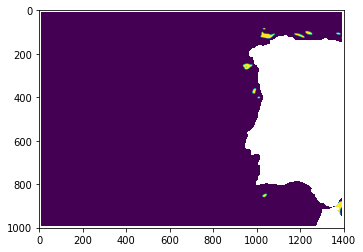

In [281]:
plt.imshow(boa)

In [282]:
np.nanmax(boa)

1.0

In [283]:
np.nanmin(boa)

0.0

In [284]:
boa

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

/home/luisfigueiredo/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/luisfigueiredo/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1401 Lists of Patches objects>)

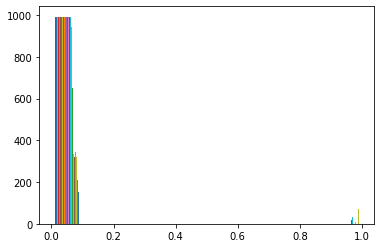

In [285]:
plt.hist(boa)

# ----------------------------------------- CCA --------------------------------------------------

In [286]:
from math import floor, ceil

np.set_printoptions(suppress=True)    #so the values in arrays don't came with that exponential format

In [298]:



##################################### Cayula-Cornillon Functions ############################################################3

def getFrontInWindow(w, head, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, 
                     minGlobalPopCohesion, corners):
    
    """
    This functions detects fronts in slidding windows. If a front is detected, the function will return
    2 1D arrays (x and y) with the coordinate values corresponding to the location of the front.
    """
    
    #empty arrays de xdata, ydata e z
    xdata, ydata = np.array([]), np.array([])
    exitType=0
    
    #mask is an array with the same shape of w, that is 1 if in that index position w = np.nan and 0 otherwise
    mask = np.isnan(w).astype('int')  
    haveNaNs = np.any(mask[:]).astype('int')  #haveNaNs=1 if mask has 1s (that correspond to NaNs in matrix w)
    n_NaNs=0
    
    
    if haveNaNs:
        n_NaNs = sum(mask.flatten()[:])                 # count nr of 1s (NaNs in matrix w) that there are
        if (n_NaNs/len(w.flatten())>0.5):               #window can't have more than 50% of its pixels as NaNs
            exitType=-1
            return None,None,None,exitType  
        
    mi_ma = [np.nanmin(w), np.nanmax(w)]                          #array with minimum and maximum value of w
    n = ceil((mi_ma[1]-mi_ma[0])/0.02)                            #number of bins
    bins = np.arange(mi_ma[0], mi_ma[1], 0.02)                    #to define the bins sequence 
    [y, xout] = np.histogram(w[:], bins, mi_ma)                   #y->frequency counts, Xout->bin location
    xout = np.mean(np.vstack([xout[0:-1],xout[1:]]), axis=0)      #xout to be relative to the centers of the bins
    
    
    thresValue = xout[0]        
    totalCount = len(w.flatten()) - n_NaNs                         #nr of non NaN pixels 
    threshPopACount, threshSeparation, threshPopAMean, threshPopBMean  = 0, -1, 0, 0
 
    
    w[mask==1] = 0                      #Replace NaNs with 0's (when mask is 1 replace values of array w for 0)
    totalSum = sum(w.flatten())                      #sum of values of matrix w
    totalSumSquares = sum(w.flatten()*w.flatten())   #sum of the squares of the values of w
    
    #In this for loop we are going to discover which line is going to make the best separation between the average
    # of population on the left and on the right (A and B) - and that is going to be the thresValue
    for k in range(1,n-1):     #ignore the first and last candidates (senão seria de 0 a n)
        popASum = sum(y[0:k+1] * xout[0:k+1])    
        popBSum = sum(y[k+1:] * xout[k+1:])  
        popACount = sum(y[0:k+1])     #sum of frequencies (y) from populationA
        popBCount = sum(y[k+1:])      #sum of frequencies (y) from populationB
    
        popAMean = popASum/popACount
        try:                                  #to avoid the zerodivisionerror that was poping up 
            popBMean = popBSum/popBCount
        except ZeroDivisionError:
            popBMean = 0
        separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean)
        if separation>threshSeparation:
            threshSeparation = separation
            thresValue = xout[k]
            threshPopACount = popACount
            threshPopAMean = popAMean
            threshPopBMean = popBMean
            
         
    #abort in case the proportion of population A is less that a certain minimum OR in case the proportion of population B is less that a certain minimum
    if (threshPopACount / totalCount < minPopProp) or (1.0 - threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None, None, exitType  
    
    #abort this window if the difference in the populations means is less than a minimum value
    if (threshPopBMean - threshPopAMean < minPopMeanDiff):   
        exitType = 2
        return None,None,None,exitType  
    
    #Calculate the criterion function THETA (TAUopt) in page 72 of the paper
    totalMean = totalSum/totalCount
    variance = totalSumSquares - (totalMean * totalMean * totalCount)
    theta = threshSeparation / (variance * totalCount)
    if (theta < minTheta):         #abort if theta is lower than a certain minimum  
        exitType = 3
        return None,None,None,exitType  
    
#Cohesion - now that we know the separation value. Based on this value we will check the matrix element by 
#element, and check whether is bigger or lower than the separation  
#we check if it's bigger bellow or to the right (when its bigger we add from one side, when its lower add to the other)
#Count the nr of times a population A cell is immediately adjacent to another popA cell and the same for popB
# A cell can be adjacent on 4 sides. Count only 2 of them (bottom and right side) because doing all 4 would be
#redundant. Do not count diagonal neighbors
    countANextToA, countBNextToB, countANextToAOrB, countBNextToAOrB  = 0, 0, 0, 0
    [n_rows, n_cols] = w.shape
    for col in range(0, n_cols-1):
        for row in range(0, n_rows-1):
            if (haveNaNs & (mask[row, col] | mask[row+1, col] | mask[row, col+1])):
                continue
                         
            #examine the bottom neighbor
            if (w[row, col] <= thresValue):                  #if matrix pixel < than the element of separation
                countANextToAOrB = countANextToAOrB + 1      #increase by 1 countANextToAOrB
                if (w[row+1, col] <= thresValue):            #if pixel of bottom row < than separation
                    countANextToA = countANextToA + 1        #increase countANextToA
            else:                                            #if pixel > than separation 
                countBNextToAOrB = countBNextToAOrB + 1      #increase countBNextToAOrB
                if (w[row+1, col] > thresValue):             #if pixel of bellow row > separation
                    countBNextToB = countBNextToB + 1        #increase countBNextToB
                         
                         
            # Examine the right neighbor
            if (w[row, col] <= thresValue):                     #if matrix pixel < separation      
                countANextToAOrB = countANextToAOrB + 1         # increase countANextToAOrB
                if (w[row, col+1] <= thresValue):               #if right pixel < separation
                    countANextToA = countANextToA + 1           # increase countANextToA
            else:                                               #if matrix pixel > separation
                countBNextToAOrB = countBNextToAOrB + 1         #increase countBNextToAOrB
                if (w[row, col+1] > thresValue):                #if right pixel > separation
                    countBNextToB = countBNextToB +1            # increase countBNextToB
                         
                         
    popACohesion = countANextToA / countANextToAOrB
    popBCohesion = countBNextToB/ countBNextToAOrB
    globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB)
    
    #These ifs are in case of errors (parameters below certain limits)
    if (popACohesion < minSinglePopCohesion) or (popBCohesion < minSinglePopCohesion) or (globalCohesion < minGlobalPopCohesion):
        exitType = 4
        return None, None,None,exitType  
                         
                         
    #OK if we reach here we have a front. Compute its contour
    X = np.linspace(head[0], head[1], n_cols)    
    Y = np.linspace(head[2], head[3], n_rows)
    if (corners.size == 0):
        w = w.astype('double')    
        if haveNaNs:
            w[w==0] = np.nan      # Need to restore the NaNs to not invent new contours around zeros
        
        c = plt.contour(X, Y, w, [thresValue])    #Create and store a set of contour lines or filled regions.
    else:
        #the 4 corners have these indices [17,32,17,32; 17,32,1,16; 1,16,1,16;1,16,17,32]
        # and the variable corners has one of its rows (the current to be retained sub-window)
        
        X = X[np.arange(corners[2]-1, corners[3])]
        Y = Y[np.arange(corners[0]-1, corners[1])]
        w = w[np.arange(corners[0], corners[1]).min()-1:np.arange(corners[0], corners[1]).max()+1, np.arange(corners[2], corners[3]).min()-1:np.arange(corners[2], corners[3]).max()+1]
        
        if  haveNaNs:
            w[w==0] = np.nan     # Need to restore the NaNs to not invent new contours around zeros
                         
        if (np.isnan(w)).all()==True:
            c = np.array([])
        else:
            c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
                     
                
        #breakpoint()
        try:
            M = c.allsegs[:]          #list of arrays for contour c. Each array corresponds to a line that may or may not be drawn. This list can have any number of arrays
        except:
            M = []
            
        M = [x for x in M if x]   #if the list has empty arrays we will drop them
        
        count = 0   #to iterate through the various arrays
        
        #Create list of booleans (True or False) wether the conditions bellow are fulfilled
        # Each array (line of contour) must have more that 7 data points and they can't be closed lines
        lista = []     
        for i in range(len(M[:])):
            lista.append([(len(x)<7 or (x[0][0]==x[-1][0] and x[0][1] == x[-1][1])) for x in M[:][i]])
            
            #if False the line will be drawn
            #if True the line will be ignored
            
        for value in lista:
            if value == [True]:
                continue        #return to the top of the for loop
            else:                    
                #For the first array of M we will take all the values of x and put them into an array                    
                x = [(M[:][count][0][i][0]).round(4) for i in range(len(M[:][count][0]))]
                
                #For the first array of M we will take all the values of y and put them into an array                    
                y = [(M[:][count][0][i][1]).round(4) for i in range(len(M[:][count][0]))]
                
                
                #save the x and y data points for each line in an xdata and ydata array
                xdata, ydata = np.append(xdata, x), np.append(ydata, y)
                
                count += 1
            
        z = thresValue
        
        if (xdata.size == 0):
            exitType = 5
            
    return xdata, ydata, z, exitType
        
        
        
def CCA_SIED(df, shape):
    
    """
    This function applies the Cayula-Cornillon Algorithm Single Image Edge Detector (CCA_SIED) to a single image data in 
    df - dataframe format. This dataframe has a column for the longitude, latitude and SST values. 
    For a single image, the function return the fronts coordinates (x,y) points 
    
    Shape is a tuple with the shape of the data: MUR (1001, 1401);   CMEMS forecast (361,505)
    """
    
    #convert the latitude and longitude columns to a numpy array
    lat = df['lat'].to_numpy()
    lon = df['lon'].to_numpy()
    
    lat = np.unique(lat).round(3)                        #get the unique values of the latitude array
    lon = np.unique(lon).round(3)                        #get the unique values of the longitude array
    
    lat_min, lat_max, lon_min, lon_max = lat.min(), lat.max(), lon.min(), lon.max()  
        
    X, Y = np.meshgrid(lon, lat)                              #create rectangular grid out of two given 1D arrays

    lat = Y.T
    lon = X.T
    
    Z = df['analysed_sst'].to_numpy(dtype ='float32').reshape(shape)
    
    head = np.array([lon_min, lon_max], dtype='float64')           
    head = np.append(head, [lat_min, lat_max])  

    z_dim = Z.shape                                                 #dimensions/shape of matrix Z (rows, cols)

    z_actual_range = np.array([np.nanmin(Z[:]), np.nanmax(Z[:])])   #range of data (minimum and maximum of matrix Z)
    nx = z_dim[1]                                                   # number of columns of matrix Z
    ny = z_dim[0]                                                   # number of rows of matrix Z
    node_offset = 0
    
    #index 4 -> minimum value of Z; index5 -> maximum value of Z; index6 -> node_offset=0
    head = np.append(head, np.array([z_actual_range[0], z_actual_range[1] , node_offset]))    
    head = np.append(head, np.array((head[1]- head[0])/(nx - int(not node_offset))))     
    head = np.append(head, np.array((head[3]- head[2])/(ny - int(not node_offset))))     

    
    #cayula;   minPopProp-> minimum proportion of each population;     minPopMeanDiff ->minimum difference between the means of the 2 populations
    minPopProp, minPopMeanDiff, minTheta, minSinglePopCohesion, minGlobalPopCohesion = 0.2, 0.4, 0.7, 0.9, 0.7       
    
    [n_rows, n_cols] = Z.shape         #nr of rows and nr of columns of matrix Z
    winW16, winW32, winW48 = 16, 32, 48

    #arrays that will store the contour of every front that will be detected
    xdata_final, ydata_final = np.array([]), np.array([])

    s=0                              #s=1 means subwindows do NOT share a common border. With s = 0 they do.

    xSide16 = winW16*head[7]
    ySide16 = winW16*head[8]
    xSide32 = (winW32 - s) * head[7]
    ySide32 = (winW32 - s) * head[8]

    nWinRows = floor(n_rows/winW16)   #times a window can slide over the rows 
    nWinCols = floor(n_cols/winW16)   #times a window can slide over the columns


    
    for wRow in range(1, nWinRows-1):    
        #start and stop indices and coords of current window
        r1 = (wRow-1) * winW16 + 1
        r2 = r1 + winW48 -s     
    
        y0 = head[2] + (wRow-1)*ySide16   
    
        for wCol in range(1, nWinCols-1):     
            c1 = (wCol - 1)*winW16+1
            c2 = c1 + winW48 - s
            x0 = head[0] + (wCol-1) * xSide16     
            wPad = Z[r1-1:r2, c1-1:c2]            # 49x49 (or 48x48 if s == 1) Window
        
            rr = np.array([1,1,2,2])
            cc = np.array([1,2,2,1])
        
            if s==1:
                corners = np.array([[17, 32, 17, 32], [17, 32, 1, 16], [1, 16, 1, 16], [1, 16, 17, 32]])  #less good
            else:
                corners = np.array([[17, 33, 17, 33], [17, 33, 1, 17], [1, 17, 1, 17], [1, 17, 17, 33]])
            
            for k in range(0,4):            #loop over the 4 slidding 32X32 sub-windows of the larger 48x48 one
                m1 = (rr[k] - 1) * winW16 + 1
                m2 = m1 + 2 * winW16 - s             #indices of the slidding 33X33 window
                n1 = (cc[k] - 1) * winW16 + 1
                n2 = n1 + 2 * winW16 - s
            
                w = wPad[m1-1:m2, n1-1:n2].astype('double')      #sub window with size 33x33
            
                #corners coordinates
                subWinX0 = x0 + (cc[k] - 1) * xSide16
                subWinX1 = subWinX0 + xSide32
                subWinY0 = y0 + (rr[k] - 1) * ySide16
                subWinY1 = subWinY0 + ySide32
            
                R = np.array([subWinX0, subWinX1, subWinY0, subWinY1])
          
                xdata, ydata, z, exitType = getFrontInWindow(w, R, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, minGlobalPopCohesion, corners[k,:])
            
                if (exitType == 0):
                   
                    xdata_final = np.append(xdata_final, xdata)
                
                    ydata_final = np.append(ydata_final,ydata)
            
                
    return xdata_final, ydata_final                

In [325]:
def CCA_front(df): 
    
    """
    This function receives a dataframe with MUR data for a individual day and plots the result
    of the aplication of the Cayula-Cornillon Algorithm
    """
    

    front = np.zeros((1001,1401))       #initialize a matrix of zeros. This shape is for the MUR data
        
    xdata_final, ydata_final = CCA_SIED(df, shape=(1001, 1401))       
    
    cols_x = np.array([])
    for value in xdata_final:                     #convert values in array x to the respective index in a (1001, 1401) matrix
        aux_x = (19+value)/0.01                  #these numbers are relative to the MUR data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in ydata_final:                     #convert values in array y to the respective index in a (1001, 1401) matrix
        aux_y = (45-value)/0.01                  #these numbers are relative to the MUR data
        rows_y = np.append(rows_y, aux_y)

    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        front[int(rows_y[i]), int(cols_x[i])] = front[int(rows_y[i]), int(cols_x[i])] + 1
        
    front[front != 0] = 1
    
    
    #Create a masked_array in order to get the continental zone well defined
    
    #Convert some df to a numpy array with the SST values for each value of longitude and latitude
    sst = df.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values   
    mask = np.isnan(np.flipud(sst))       #Boolean array=True where array Temp had Null values (continental zone)
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True 
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    cca_front = np.ma.masked_where(mask_dilated==255, front)  
    
    #cca_front = np.flipud(cca_front) 
    
    #cca_front[cca_front == 255] = 1
    
    return cca_front

/tmp/ipykernel_6027/3035077971.py:151: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
/tmp/ipykernel_6027/3035077971.py:53: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount


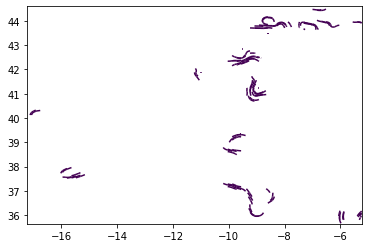

In [326]:
cca_frente = CCA_front(df_ex)

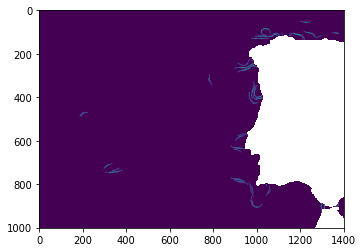

In [327]:
plt.imshow(cca_frente)

In [337]:
np.nanmax(cca_frente)

1.0

In [329]:
np.nanmin(cca_frente)

0.0

In [336]:
cca_frente.max()

1.0

In [335]:
cca_frente

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., --, --, --],
        [0.0, 0.0, 0.0, ..., --, --, --],
        [0.0, 0.0, 0.0, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=1e+20)

(array([[1001.,    0.,    0., ...,    0.,    0.,    0.],
        [1001.,    0.,    0., ...,    0.,    0.,    0.],
        [1001.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [1001.,    0.,    0., ...,    0.,    0.,    0.],
        [1001.,    0.,    0., ...,    0.,    0.,    0.],
        [1001.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1401 Lists of Patches objects>)

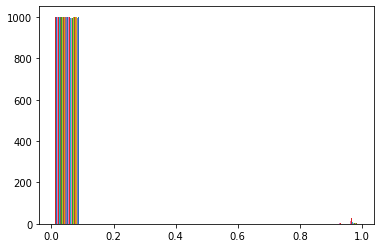

In [338]:
plt.hist(cca_frente)

In [339]:
cca_frente[cca_frente == 255] = 1

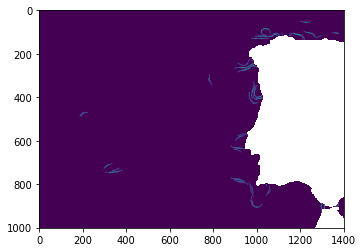

In [340]:
plt.imshow(cca_frente)

In [342]:
cca_frente.min()

0.0

# -----------------------------------------------------------------------------------------------

In [135]:
class Employee:
    
    num_employees = 0
    
    raise_amount = 1.04
    
    def __init__(self, first, last, pay):
        self.first = first
        self.last = last
        self.pay = pay
        self.email = first + '.' + last + '@colabatlantic.com'
        
        Employee.num_employees += 1
        
    def fullname(self):
        return '{} {}'.format(self.first, self.last)
    
    def apply_raise(self):
        self.pay = int(self.pay * self.raise_amount)

    @classmethod   #decorator->allows user to add new functionality to existing object without modifying its structure.
    def set_raise_amt(cls, amount):   #agora recebemos a class como 1º arg em vez da instance variable (self)
        cls.raise_amount = amount
        
    @classmethod
    def from_string(cls, emp_str):
        first, last, pay = emp_str.split('-')
        return cls(first, last, pay)
    
    #function that receives a date and say if it was work day
    #Usam-se Static Methods quando não vamos ter de aceder à instance nem à class durante a função
    @staticmethod # static methods don't take the instance (self) or the class as the first argument
    def is_workday(day):
        if day.weekday() == 5 or day.weekday() == 6:   #se for sabado ou domingo
            return False
        return True

class Developer(Employee):   #Inherit from the Employee class
    
    #Visto que queremos que o exista o attribute programming language na class Developer:
    def __init__(self, first, last, pay, prog_lang):
        
        raise_amount = 1.1
        
        #We are calling the parent class init method. Both of this are the same basically
        super().__init__(first, last, pay)
        #Employee.__init__(self, first, last, pay)
        self.prog_lang = prog_lang
        
        
class Manager(Employee):
    
    #You don't want to pass mutable data types (lists, dictionaires, ..) as default arguments
    def __init__(self, first, last, pay, employees=None):
        super().__init__(first, last, pay)
        if employees is None:
            self.employees = []
        else:
            self.employees = employees
            
    #option the adicionar um tirar employees dum certo manager
    def add_employee(self, emp):
        if emp not in self.employees:
            self.employees.append(emp)
            
    def remove_employee(self, emp):
        if emp in self.employees:
            self.employees.remove(emp)
            
    #method that will print all the employees that this manager supervizies
    def print_emps(self):
        
        for emp in self.employees:
            print('-->', emp.fullname())
        
        

In [128]:
dev1 = Developer('Luis', 'Figueiredo', 1600, 'Python')
dev2 = Developer('Gui', 'Eugenio', 1600, 'Java')

In [137]:
man1 = Manager('Caio', 'Fonteles', 2600, [dev1])
man2 = Manager('Nuno', 'Loureiro', 3000, [dev2])

In [130]:
print(man2.print_emps())

--> Gui Eugenio
None


In [133]:
man2.add_employee(dev1)
man2.remove_employee(dev2)

In [134]:
print(man2.print_emps())

--> Luis Figueiredo
None


In [139]:
#diz-nos se um object é uma instance duma dada classe
print(isinstance(man1, Manager))   #man1 é uma instance da class Manager

print(isinstance(dev1, Manager))    #dev1 não é uma instance da class Manager mas sim da class developer

True
False


In [140]:
print(isinstance(man1, Employee))  
#man1 é uma instance da class Employee pq a class Manager é uma sub-class da class Employee

True


In [141]:
print(issubclass(Developer, Employee))
#Developer é uma subclass de Employee

True


In [142]:
print(issubclass(Developer, Manager))
#Mas Developer não é uma subclass de Manager

False


In [110]:
print(help(Developer))

Help on class Developer in module __main__:

class Developer(Employee)
 |  Developer(first, last, pay)
 |  
 |  Method resolution order:
 |      Developer
 |      Employee
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  raise_amount = 1.1
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Employee:
 |  
 |  __init__(self, first, last, pay)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  apply_raise(self)
 |  
 |  fullname(self)
 |  
 |  ----------------------------------------------------------------------
 |  Class methods inherited from Employee:
 |  
 |  from_string(emp_str) from builtins.type
 |  
 |  set_raise_amt(amount) from builtins.type
 |  
 |  ----------------------------------------------------------------------
 |  Static methods inherited from Employee:
 |  
 |  is_workday(day)
 |      #function that receives a date and say if it was work day
 |      #

In [111]:
#INHERITANCE -> allow us to inherit attributes and methods from the parent class

In [112]:
print(dev1.pay)
dev1.apply_raise()
print(dev1.pay)

1600
1760


In [145]:
from matplotlib.dates import date2num

In [146]:
day_txt = '20220913'

In [147]:
date_obj = datetime.datetime.strptime(day_txt+' 00:00:00', '%Y%m%d %H:%M:%S')
date_time = date2num(date_obj)

In [148]:
date_time

738411.0

In [149]:
t = datetime.datetime(2022, 9, 14, 0, 0)

(t-datetime.datetime(2004,1,1)).total_seconds()
    

590198400.0